# Evaluaciíon

In [1]:
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import json

import huggingface_hub
from huggingface_hub import hf_hub_download

from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification

import torch
from torch.utils.data import RandomSampler

from torch.utils.data import DataLoader, Dataset

from transformers import TrainingArguments, Trainer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

import os



In [2]:

# huggingface_hub.notebook_login()

hf_dataset_id = "ethz/food101"
ds = load_dataset(hf_dataset_id)
id2label = json.load(open("id2label.json"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {label:id for id,label in id2label.items()}
numclasses = len(id2label)
print(id2label)
print(numclasses)

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake', 15: 'ceviche', 16: 'cheesecake', 17: 'cheese_plate', 18: 'chicken_curry', 19: 'chicken_quesadilla', 20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder', 25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes', 30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots', 36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt', 46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon', 51: 'guacamole

In [3]:
trainds = ds['train']
testds = ds['validation']

In [4]:
# Voy a quitar los indices que causan problemas
exclude_idx = [18508, 23754, 56094]

# create new dataset exluding those idx
trainds = trainds.select(
    (
        i for i in range(len(trainds)) 
        if i not in set(exclude_idx)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x000001E4A514F840> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [5]:
trainds

Dataset({
    features: ['image', 'label'],
    num_rows: 75747
})

In [6]:

model_name = 'google/vit-base-patch32-384'
model_dir = 'trained_model2'
model_new = ViTForImageClassification.from_pretrained(model_dir)
processor = ViTImageProcessor.from_pretrained(model_name)


In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset        
        self.transform = transform
        # model_name = 'google/vit-base-patch16-224-in21k'
        model_name = 'google/vit-base-patch32-384'
        self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        label = self.dataset[idx]['label']
        image = self.dataset[idx]['image']
        # aplico transformacione estandar requeridas por el modelo
        image = self.processor(images=image, return_tensors="pt")
        # obtengo los valores
        pixel_values = image['pixel_values']
        # Remuevo dimensióne extra
        pixel_values = pixel_values.squeeze()
        if self.transform:
            image = self.transform(image)
        return {'pixel_values':pixel_values, 'label': label}

In [8]:

train_dataset = CustomImageDataset(trainds)
test_dataset = CustomImageDataset(testds)


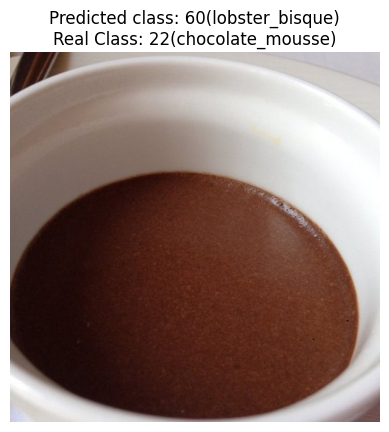

In [9]:
i = np.random.randint(10000)
imagen = testds[i]['image']
label = testds[i]['label']
inputs = processor(images=imagen, return_tensors="pt")
outputs = model_new(**inputs)
# outputs = model_ft(train_dataset[5]['pixel_values'].unsqueeze(0))
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])
predicted_class = model_new.config.id2label[predicted_class_idx]

plt.imshow(imagen)
plt.axis('off') 
plt.title(f'Predicted class: {predicted_class_idx}({predicted_class})\nReal Class: {label}({id2label[label]})')
plt.show()

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

test_dataloader = DataLoader(test_dataset, batch_size=64)

model_new.to(device)
model_new.eval()
correct = 0
total = 0

y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch['pixel_values'].float()
        labels = batch['label']
        
        outputs = model_new(pixel_values=pixel_values.to(device))
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions.to('cpu') == labels).sum().item()
        total += labels.size(0)
        
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.to('cpu').tolist())

accuracy = correct / total
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cuda


d:\Users\jpschamunTMP\anaconda3\envs\ViT\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Test Accuracy: 87.57%
Precision: 0.88
Recall: 0.88
F1-Score: 0.88
